# Dendrites: Current Clamp IV + Spikes

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. The first time you run this code notebook, you will get a popup asking to choose which version of Python to use (the python "kernel"). **Choose the python kernel called "CSHL_IonChannels"**

    - If you did it correctly, you should see "CSHL_IonChannels (Python 3.11.13)" in the top right of the screen.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data file you want to analyze

#### Put the .abf files with your Ih recordings in the "data/Dendrites" folder

In [2]:
data_folder = "data/11-Dendrites"

import os
print("Folders:")
for subdir in os.listdir(data_folder):
    if os.path.isdir(data_folder + "/" + subdir):
        print(f"'{data_folder}/{subdir}'")

from glob import glob
print("Files:")
data_files = glob(data_folder+"/*.abf")
data_files.sort()
data_files

Folders:
Files:


['data/11-Dendrites/2025_06_18_0038.abf',
 'data/11-Dendrites/2025_06_18_0039.abf',
 'data/11-Dendrites/2025_06_18_0040.abf',
 'data/11-Dendrites/2025_06_18_0041.abf',
 'data/11-Dendrites/2025_06_18_0042.abf',
 'data/11-Dendrites/2025_06_18_0043.abf',
 'data/11-Dendrites/2025_06_18_0044.abf',
 'data/11-Dendrites/2025_06_18_0045.abf',
 'data/11-Dendrites/2025_06_18_0046.abf']

You should see a list of files above (assuming you put the data in the correct folder)

Choose which file you want to analyze and copy/paste the file name here:

In [3]:
# data_file = 'data/11-Dendrites/2025_06_18_0039.abf'
data_file = 'data/11-Dendrites/2025_06_18_0045.abf'

Now we can load the file and plot the raw data:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

Trace('2025_06_18_0045.abf')
Number of sweeps: 20
Points per sweep: 20,000
Duration per sweep: 2.000 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage


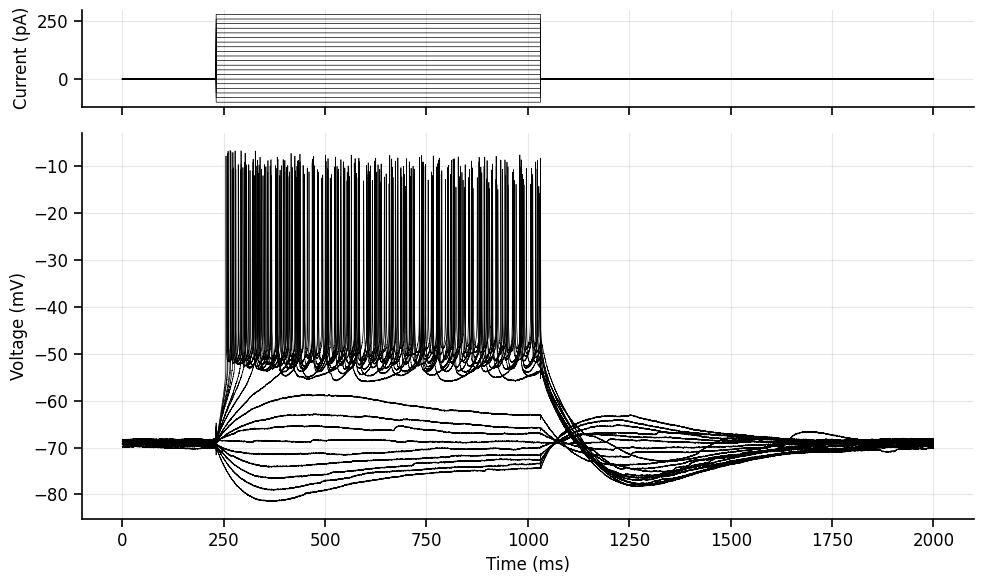

Voltage step time: [231.1] to [1031.1] ms


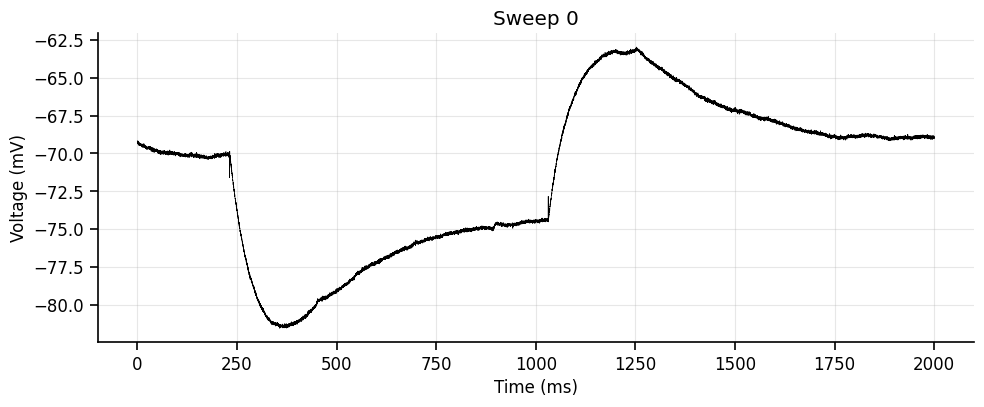

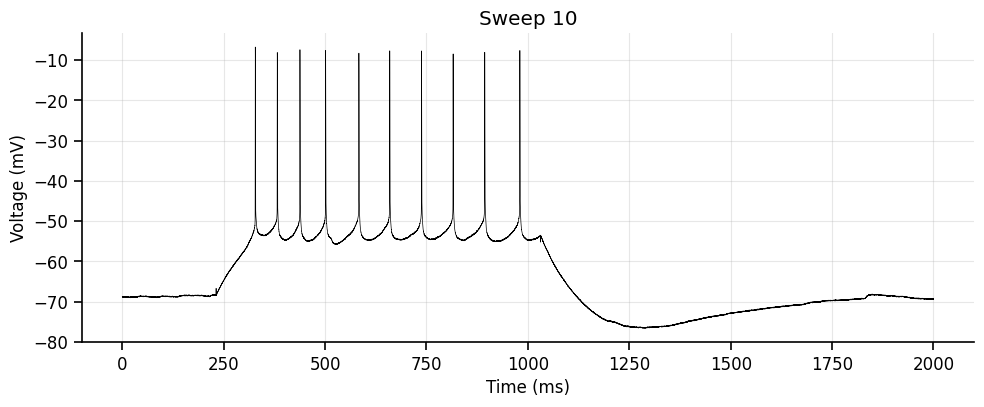

In [4]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              scaling=[1, 1/20],
                              units=['pA', 'mV'],
                              recording_mode='current clamp')
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)


# ----------------------------------------------------------------------------------------------------------------
# The %matplotlib widget lines makes plots interactive (but sometimes is a bit buggy, doesn't always work)

# %matplotlib widget
%matplotlib inline
ax = traces.plot(plot_voltage=True, sweep='all', time_units=time_units, height_ratios=(1,4))
plt.show()

v_step_start = traces.get_step_events(threshold=traces.current_data[0,0]-5, channel='current', edge='rising', polarity='negative', time_units=time_units, sweep=0)
v_step_end = traces.get_step_events(threshold=traces.current_data[0,0]-5, channel='current', edge='falling', polarity='negative', time_units=time_units, sweep=0)
print(f"Voltage step time: {v_step_start} to {v_step_end} ms")
try:
    x_axis_range = (v_step_start[0]-10, v_step_end[0]+10)
except:
    x_axis_range = (v_step_start[0], v_step_end[0])

ax = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep=0)
ax.set_title(f"Sweep 0")
plt.show()

ax = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep=traces.num_sweeps//2)
ax.set_title(f"Sweep {traces.num_sweeps//2}")
plt.show()

## 2. Signal processing

### Baseline the trace and apply highpass / lowpass / bandpass filtering

We want to measure the current amplitude relative to the baseline before the stimulus starts.  

Depending on you recording, you may also have 50/60 Hz line noise, high-frequency noise, or slow drift in your recording that we can correct for.

You can run this next cell as many times as you want to fine-tune the filtering parameters:

BASELINE SUBTRACTED:
Baseline voltages (mV): [-70.0558 -69.4486 -69.6227 ... -69.4049 -69.7148 -69.2864]


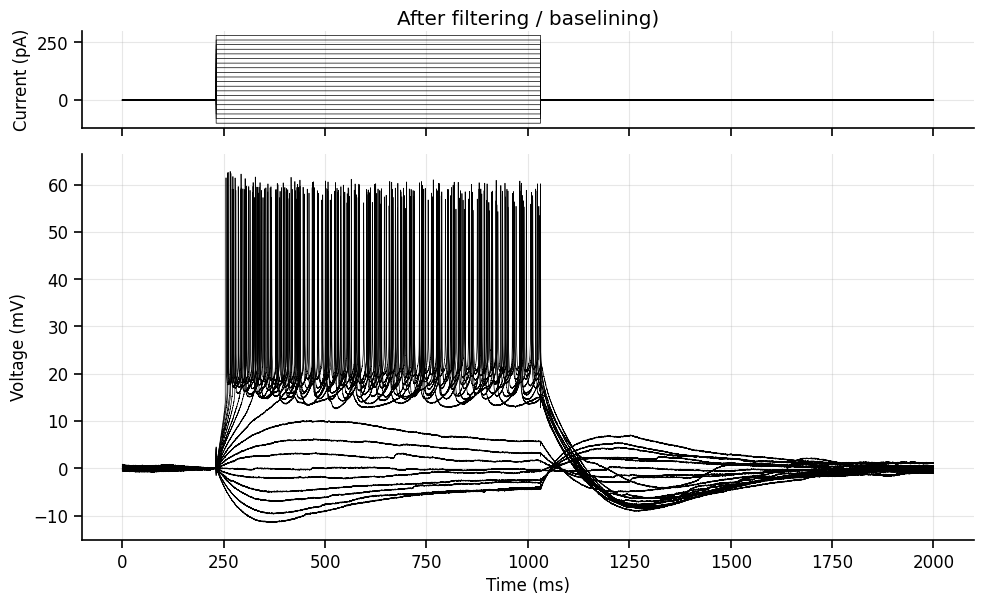

In [5]:
subtract_baseline = True    # Subtract baseline to measure the current relative to the baseline (just before the voltage step)

linear_detrending = False   # Detrend the data to remove linear or constant trends (e.g slow drift)
lowpass_filter    = False   # Lowpass filter (removes high-frequency noise)
bandpass_filter   = False   # Bandpass filter (removes 50/60 Hz mainline noise)


# ----------------------------------------------------------------------------------------------------------------
filtered_traces = traces.copy()
if linear_detrending:
    # Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

if lowpass_filter:
    # Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 4000) # Choose a value in units of Hz
    
if bandpass_filter:
    # Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

if subtract_baseline:
    start_baseline = max(0, v_step_start[0]-5)  # Start time for baseline subtraction
    end_baseline = v_step_start[0]  # End time for baseline subtraction
    filtered_traces.subtract_baseline(start_time = start_baseline, end_time = end_baseline , time_units = time_units, channel = 'voltage')

# Plot the traces before and after filtering
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    # %matplotlib widget
    %matplotlib inline
    ax = filtered_traces.plot(plot_voltage=True, plot_current=True, sweep='all', time_units=time_units, height_ratios=(1,4))
    ax[0].set_title('After filtering / baselining)', y=0.98)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [6]:
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    print("Applied filtering and/or baseline subtraction to the traces.")
    traces = filtered_traces

Applied filtering and/or baseline subtraction to the traces.


## 2. Measure Sag potential (caused by $I_{H}$ current)

#### To measure the Sag potential, we need to measure the peak voltage as well as the steady state voltage.

In [7]:
# 1. Get the time of the negative current step
holding_current = traces.current_data[0,0]
step_start = traces.get_step_events(threshold=holding_current-5, channel='current', edge='rising', polarity='negative', time_units=time_units, sweep=0)
step_end = traces.get_step_events(threshold=holding_current-5, channel='current', edge='falling', polarity='negative', time_units=time_units, sweep=0)

step_start = step_start[0]
step_end = step_end[0]
print("Double check that these numbers look correct:")
print(f"Step start: {step_start} {time_units}")
print(f"Step end: {step_end} {time_units}")

Double check that these numbers look correct:
Step start: 231.1 ms
Step end: 1031.1000000000001 ms


To avoid measuring spikes, we will only analyze the hyperpolarizing steps (negative current injection)

In [8]:
current_steps,_ = traces.get_measurements(start_time=step_start+5, end_time=step_end-5, measurement_type='mean', time_units=time_units)
hyperpolarizing_idx = np.where(current_steps < 0)[0]
print(f"Hyperpolarizing steps (index): {hyperpolarizing_idx}")
print(f"hyperpolarizing currents (pA): {current_steps[hyperpolarizing_idx]}")

Hyperpolarizing steps (index): [0 1 2 3 4]
hyperpolarizing currents (pA): [-100.  -80.  -60.  -40.  -20.]


/Users/ag1880/github-repos/CSHL_IonChannels2025/CSHL_IonChannels/utils.py:1388: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if sweep == 'all':


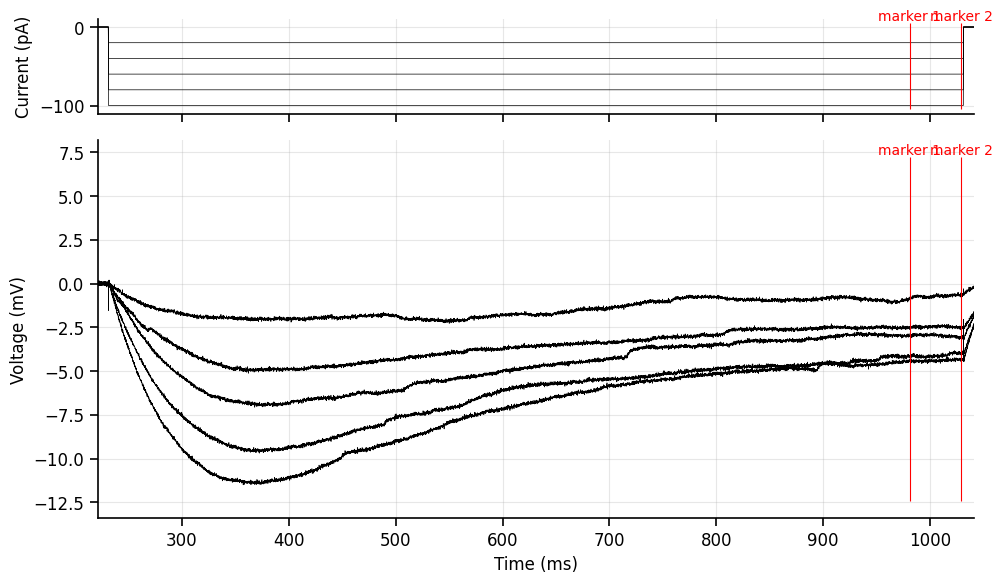

In [9]:
# The markers here define where we will measure the steady-state voltage (at the end of the step)
marker_1 = step_end - 50
marker_2 = step_end - 2

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax1,ax2 = traces.plot(plot_voltage=True, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep=hyperpolarizing_idx, height_ratios=[1,4])
ax1.set_xlim(step_start-10,step_end+10)
ax2.set_xlim(step_start-10,step_end+10)
plt.show()

In [10]:
# 1. Measure the Sag peak
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'
_, peak_voltage = traces.get_measurements(start_time=step_start+5, end_time=step_end-5,
                                                    measurement_type=measurement_type, time_units=time_units)

# 2. Measure the steady state voltage
measurement_type = 'mean' # Options: 'mean', 'max', 'min', 'peak'
current_steps, ss_voltage = traces.get_measurements(start_time=marker_1, end_time=marker_2,
                                                    measurement_type=measurement_type, time_units=time_units)

# %matplotlib inline
# sweep_idx = range(0,9)
# current_steps = current_steps[sweep_idx]
# voltage_steps = voltage_steps[sweep_idx]
# ax = plot_IV(voltage_steps, current_steps)# ,xlabel_coords=(0.95,0.25),ylabel_coords=(0.35,0.6))
# ax.set_title(f'Sag peak voltage vs current step')
# plt.show()

#### Now we can plot the difference between the peak and steady-state voltage

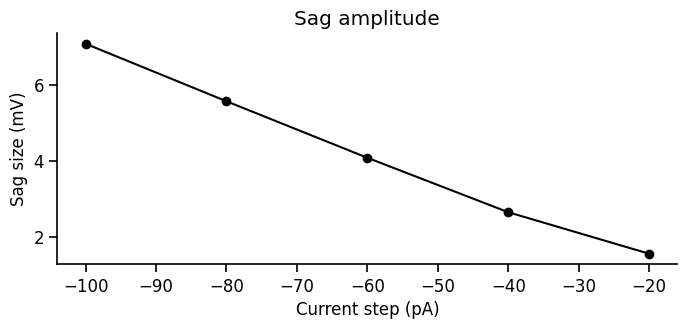

In [11]:
sag_size = np.abs(peak_voltage - ss_voltage)

sag_size = sag_size[hyperpolarizing_idx]
x_axis = current_steps[hyperpolarizing_idx]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x_axis, sag_size, marker='o', color='black')
ax.set_xlabel(f'Current step ({traces.current_unit})')
ax.set_ylabel(f"Sag size ({traces.voltage_unit})")
ax.set_title(f"Sag amplitude")
plt.show()


#### We can also plot this as a ratio (Sag amplitude relative to the peak voltage)

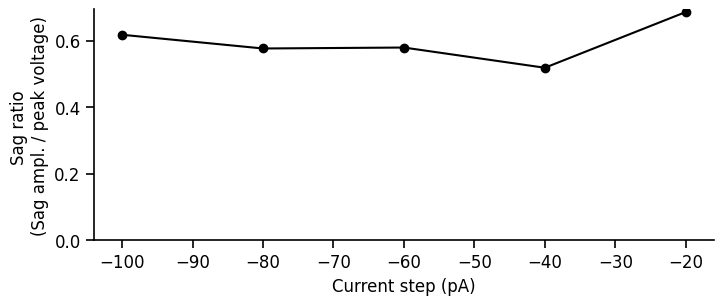

In [12]:
sag_size = np.abs(peak_voltage - ss_voltage) / np.abs(peak_voltage)
sag_size = sag_size[hyperpolarizing_idx]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x_axis, sag_size, marker='o', color='black')
ax.set_xlabel(f'Current step ({traces.current_unit})')
ax.set_ylabel(f"Sag ratio \n(Sag ampl. / peak voltage)")
ax.set_ylim(bottom=0)
plt.show()


## 3. Measure firing rate to get FI curve

/Users/ag1880/github-repos/CSHL_IonChannels2025/CSHL_IonChannels/utils.py:2776: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_properties[key] = np.array(spike_properties[key])


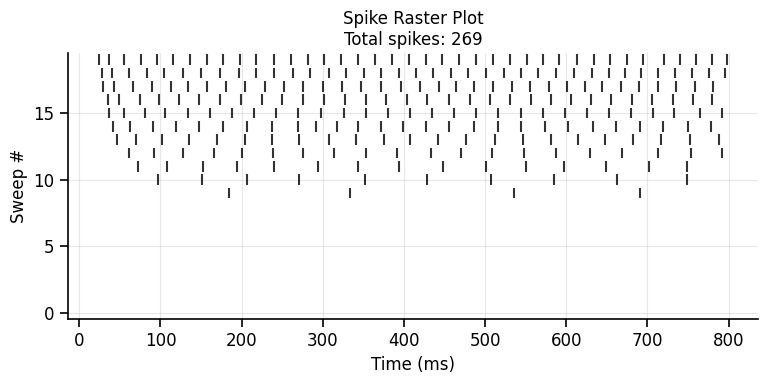


Spike Detection Summary:
Total spikes detected: 269
Number of sweeps: 20
Spikes per sweep: 13.45 ± 14.54
Sweep duration: 0.80 s
Overall spike rate: 16.81 Hz


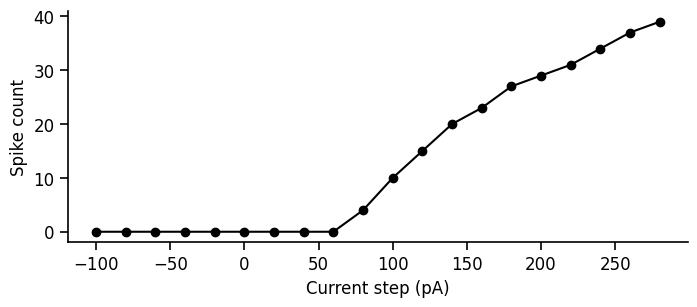

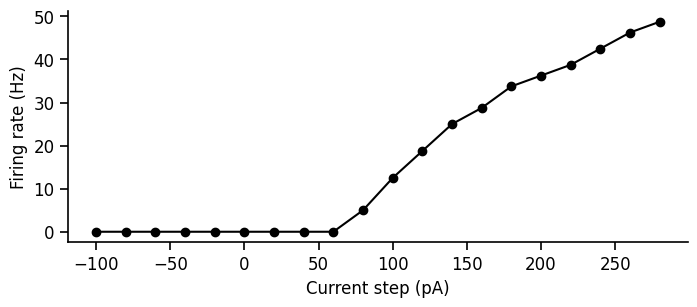

In [13]:
traces_during_stim = traces.crop(timepoint=step_start, timepoint_2=step_end, time_units=time_units)
spike_properties = traces_during_stim.detect_spikes(threshold=0, time_units=time_units, plot=True)

spike_counts = spike_properties['spike_counts']

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(current_steps, spike_counts, '-o', color='black')
ax.set_xlabel(f'Current step ({traces.current_unit})')
ax.set_ylabel('Spike count')
# ax.set_ylim(bottom=-1)
plt.show()

total_time_s = traces_during_stim.total_time
firing_rate = spike_counts / total_time_s
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(current_steps, firing_rate, '-o', color='black')
ax.set_xlabel(f'Current step ({traces.current_unit})')
ax.set_ylabel('Firing rate (Hz)')
# ax.set_ylim(bottom=-2)
plt.show()


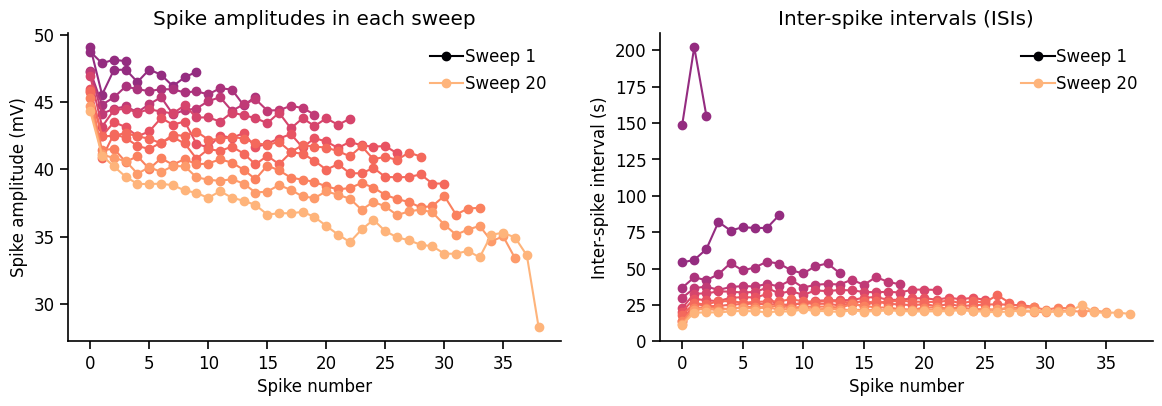

In [14]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14, 4))
cmap = plt.get_cmap('magma', traces.num_sweeps)
colors = [cmap(i**0.95/traces.num_sweeps) for i in range(traces.num_sweeps)]

# Plot spike amplitudes
spike_amplitudes_list = spike_properties['prominences']
for i,spike_amplitudes in enumerate(spike_amplitudes_list):
    if i==0 or i==len(spike_amplitudes_list)-1:
        ax1.plot(spike_amplitudes, marker='o', color=colors[i], label=f'Sweep {i+1}')
    else:
        ax1.plot(spike_amplitudes, marker='o', color=colors[i])
ax1.legend()
ax1.set_ylabel(f"Spike amplitude ({traces.voltage_unit})")
ax1.set_title('Spike amplitudes in each sweep')
ax1.set_xlabel('Spike number')

# Plot inter-spike intervals (ISIs)
spike_times_list = spike_properties['spike_times']
for i,spike_times in enumerate(spike_times_list):
    isi = np.diff(spike_times)  
    if i==0 or i==len(spike_times_list)-1:
        ax2.plot(isi, marker='o', color=colors[i], label=f'Sweep {i+1}')
    else:
        ax2.plot(isi, marker='o', color=colors[i])
ax2.legend()
ax2.set_xlabel('Spike number')
ax2.set_ylabel('Inter-spike interval (s)')
ax2.set_title('Inter-spike intervals (ISIs)')
ax2.set_ylim(bottom=0)
plt.show()